In [206]:
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns
import pandas as pd
import numpy as np

df = pd.read_excel("encoded_db-1.xlsx", usecols = [2,3,5,7,9,11,13,15,17,19,21,23])

## Chequeo de columna de productos

El código se encarga de checar si se cumple el formato de "Producto (Número producto)" para cada registro en la columna

In [207]:
df1 = df.copy()
df1["Productos"] = df1["Encoded Products"].str.extract("(Producto [0-9]*)")
print(df1["Productos"].isnull().sum()) # Deben ser 0 valores nulos

0


# Chequeo formato de los meses

Esto se hace con el propósito de observar si hay uniformidad en el formato de las fechas que vienen en strings y también de qu no haya alguna otro dato extraño. Lo esperado es que los meses estén en formato corto y en minúsculas.

In [208]:
df1["date"] = df1["date"].str.strip()
df1["mes"] = df1["date"].str.extract("[0-9]* ([a-zA-Z]*) [0-9]{4}")
print(df1["mes"].unique())

['ene' 'feb' 'mar' 'abr' 'may' 'jun' 'jul' 'ago' 'sep' 'oct' 'nov' 'dic']


Ya sabiendo el formato de las fechas se hacen los cambios pertinentes para hacer un correcto cambio de tipo de dato (String a fecha)

In [209]:
df["date"] = df["date"].str.strip()

cambio_meses = {
    'ene': 'Jan',
    'feb': 'Feb',
    'mar': 'Mar',
    'abr': 'Apr',
    'may': 'May',
    'jun': 'Jun',
    'jul': 'Jul',
    'ago': 'Aug',
    'sep': 'Sep',
    'oct': 'Oct',
    'nov': 'Nov',
    'dic': 'Dec'
}

df['date'] = df['date'].replace(cambio_meses, regex=True)
df['date'] = pd.to_datetime(df['date'], format='%d %b %Y')

## Top 5 productos con mayores ordenes

Se obtendrá el top 5 con la finalidad de identificar cuáles son los que se llegan a solicitar más durante el tiempo

In [210]:
df['Suma Total'] = df.iloc[:,2:].sum(axis=1) # número ordenes por producto (Hay duplicados)
df = df[["date", "Encoded Products", "Suma Total"]]
df1 = df.groupby(by = "Encoded Products")["Suma Total"].sum().sort_values(ascending=False)[0:5] # número ordenes por producto (Ya no hay duplicados)
df1

Encoded Products
Producto 273    111660.5
Producto 0       23499.0
Producto 1       18602.5
Producto 5       11158.0
Producto 8        6639.5
Name: Suma Total, dtype: float64

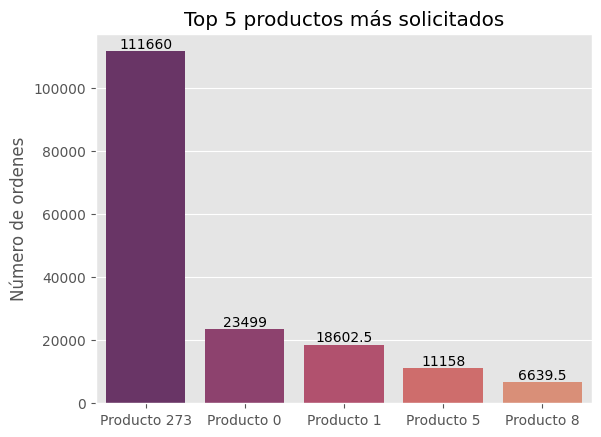

In [211]:
color = sns.color_palette("flare", n_colors=5)
color.reverse()

ax = sns.barplot(df1, palette = color)
ax.set(xlabel=None)

for i in ax.containers:
    ax.bar_label(i,)

plt.ylabel("Número de ordenes")
plt.title("Top 5 productos más solicitados")
plt.show()

## Chequeo de gaps en fechas

Se puede observar de la lista que del año 2022 faltan los meses octubre, noviembre y diciembre.

In [212]:
df["date"].dt.strftime("%Y-%m").unique()

array(['2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06',
       '2022-07', '2022-08', '2022-09', '2022-10', '2022-11', '2022-12',
       '2023-01', '2023-02', '2023-03', '2023-04', '2023-05', '2023-06',
       '2023-07', '2023-08', '2023-09', '2023-10', '2023-11', '2023-12'],
      dtype=object)

## Gráfica de serie temporal

En la gráfica se puede observar que al principio del 2022 hay una cantidad baja de artículos ordenados del producto 273, pero a medida que avanza el tiempo esta estabilidad cambia y aumentan las ordenes creando una "estabilidad" reflejada por la media que pareciese encontrarse en 1000, es decir, pareciese observarse que las ordenes, en su media, es 1000, también hay presencia de valles y picos y a finales del año 2023 son más notables sin embargo pareciese que aumentan un poco más las órdenes. Por lo tanto y por lo dicho anteriormente se pueden apreciar comportamientos de tendencia y ciclicidad (Este último no tan notable y visto en cada gap de la serie temporial al igual que la tendencia)

In [213]:
df2 = df.copy()
df2.query("`Encoded Products` == 'Producto 273'", inplace=True)
df2["weeks"] = df2["date"].dt.strftime("%Y - %W") # Genera número de la semana de cada fecha
df2 = df2.groupby(by = "weeks")["Suma Total"].sum()
fig = px.line(df2, x = df2.index, y = df2.values,
        labels={
                "weeks": "Número de semana",
                "y": "Ordenes Totales",
                },
        markers=True)
fig.show()


## Prueba para trend y ciclicidad (Mostrado en la parte de Stationarity)

Esto se hace para reconocer qué modelos se usarán en base a los comportamientos de la serie temporal.

Trend: Se puede confirmar que, efectivamente, hay una trend positiva como se mencionaba previamente.

In [214]:
import pymannkendall as mk

mk.original_test(df2.values)

Mann_Kendall_Test(trend='increasing', h=True, p=6.858957846134217e-13, z=7.182211344517501, Tau=0.5060776063581113, s=2165.0, var_s=90781.66666666667, slope=16.10421686746988, intercept=466.7060240963855)

## Stationarity (Using differencing)

Por la presencia del trend lo datos no son estacionarios y se necesita que este requisito sea cumplido con el objetivo de aplicar un modelo para predicciones con mejor precisión.

Para el código de abajo se usan los datos sin haber hecho el differencing con el propósito de observar en la función de autocorrelación qué lags en las fechas están más relacionadas para las predicciones de los datos actuales, asimismo para observar comportamientos. En los cuales se puede confirmar que hay una presencia de ciclicidad por los picos en los resultados de correlación y significancia de los resultados mostrados.

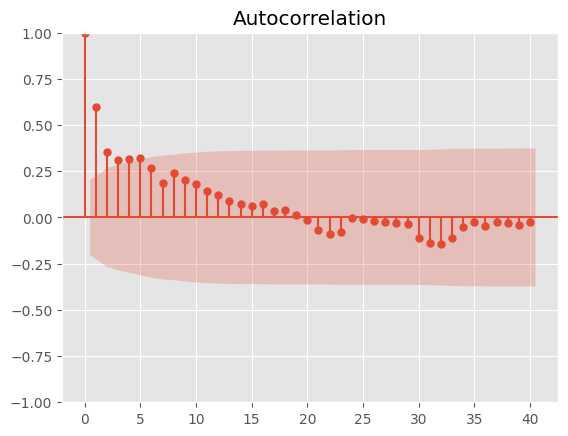

In [215]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df2, lags = 40)
plt.show()

### Identificación del mejor shift en las fechas

Los mejores resultados son cuando el shift son 2 o 3 días. (Preferiblemente 2 porque al parecer hay un componente de temporalidad y al principio se pensaba que era de ciclicidad, por lo que se necesita remover)

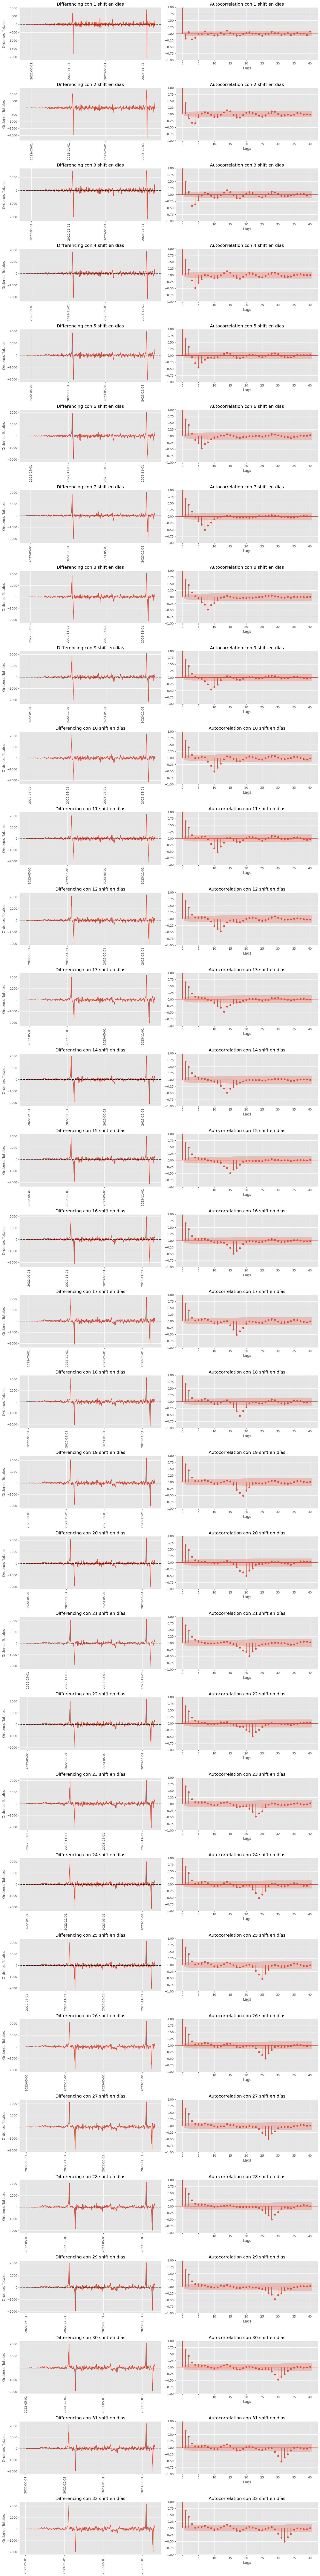

In [216]:
from statsmodels.graphics.tsaplots import plot_acf

fig, axs = plt.subplots(32, 2, figsize=(15, 120))

for counter in range(32):
    df3 = df.copy()
    df3.query("`Encoded Products` == 'Producto 273'", inplace=True)
    df3.drop(columns="Encoded Products", inplace = True)
    df3 = df3.groupby("date", as_index=False)["Suma Total"].sum()
    full_dates = pd.DataFrame(pd.date_range(start=df3["date"].min(), end=df3["date"].max()), columns = ["date"]) # Se crea una serie de panads donde contenga todas las fechas 
    # (de cada día) del producto 273, aun cuando no se haya vendido en ciertos días, esto con el propósito de tener uniformidad en fechas

    merged_df = pd.merge(full_dates, df3, on='date', how='left')
    merged_df.fillna({"Suma Total":0}, inplace=True)
    merged_df.set_index("date", inplace = True)

    merged_df_previous_values = merged_df.shift(counter + 1).dropna() # Se elimina la primera fecha por el shift que se hizo
    merged_df = merged_df.iloc[counter + 1:] # Se excluye la primera fecha en la primera iteración 

    differenced_orders = merged_df - merged_df_previous_values

    axs[counter, 0].plot(differenced_orders)
    axs[counter, 0].axhline(0, color='black', linestyle='--', linewidth=1)
    axs[counter, 0].set_title(f"Differencing con {counter + 1} shift en días")
    axs[counter, 0].set_ylabel("Ordenes Totales")

    axs[counter, 0].tick_params(axis='x', rotation=90)
    axs[counter, 0].set_xticks(axs[counter, 0].get_xticks()[::3])

    plot_acf(differenced_orders, lags=40, ax=axs[counter, 1])
    axs[counter, 1].set_title(f"Autocorrelation con {counter + 1} shift en días")
    axs[counter, 1].set_xlabel("Lags")
    
plt.tight_layout() 
plt.show()

### Prueba de estacionaridad para shift de 7 días

El p_value resultó ser demasiado bajo en el augmented Dickey-Fuller test lo cual es bueno pues indica una excelente estacionaridad en los datos. En el código se compara ese resultado con el de antes de haber hecho el differencing en los datos.

In [217]:
from statsmodels.tsa.stattools import adfuller

df3 = df.copy()
df3.query("`Encoded Products` == 'Producto 273'", inplace=True)
df3.drop(columns="Encoded Products", inplace = True)
df3 = df3.groupby("date", as_index=False)["Suma Total"].sum()
full_dates = pd.DataFrame(pd.date_range(start=df3["date"].min(), end=df3["date"].max()), columns = ["date"]) # Se crea una serie de panads donde contenga todas las fechas (de cada día)
# del producto 273, aun cuando no se haya vendido en ciertos días, esto con el propósito de tener uniformidad en fechas
merged_df = pd.merge(full_dates, df3, on='date', how='left')
merged_df.fillna({"Suma Total":0}, inplace=True)
merged_df.set_index("date", inplace = True)

merged_df_previous_values = merged_df.shift(periods = 7).dropna() # Se elimina la primera fecha por el shift que se hizo
merged_df = merged_df.iloc[7:] # Se excluye la primera fecha en la primera iteración 

merged_df.index = merged_df.index.strftime("%Y - %W") # Genera número de la semana de cada fecha
merged_df = merged_df.groupby(by = merged_df.index)["Suma Total"].sum()

merged_df_previous_values.index = merged_df_previous_values.index.strftime("%Y - %W") # Genera número de la semana de cada fecha
merged_df_previous_values = merged_df_previous_values.groupby(by = merged_df_previous_values.index)["Suma Total"].sum()

differenced_orders = merged_df - merged_df_previous_values

print("P_value es:", adfuller(differenced_orders)[1], "tras haber aplicado el método de differencing")
print("P_value es:", adfuller(df2)[1], "sin haber aplicado el método de differencing en los datos reales")

P_value es: 3.386442081585043e-08 tras haber aplicado el método de differencing
P_value es: 9.62752794095789e-05 sin haber aplicado el método de differencing en los datos reales


## Cross validation (Una semana como test)

In [218]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits = 7, test_size=1)
X = differenced_orders.index.values # Ya se encuentra todo ordenado por fecha
Y = differenced_orders.values

for i, (train_index, test_index) in enumerate(tss.split(X)):
    print(f"Fold {i+1}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

# Por el momento es solo del último Fold los datos de entrenamiento y test

X_train = differenced_orders.iloc[train_index]
Y_train = differenced_orders.iloc[test_index]

Fold 1:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84]
  Test:  index=[85]
Fold 2:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85]
  Test:  index=[86]
Fold 3:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86]
  Test:  index=[87]
Fold 4:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 1

## Forecasting Methods (Solo una semana de predicción)

### ARIMA

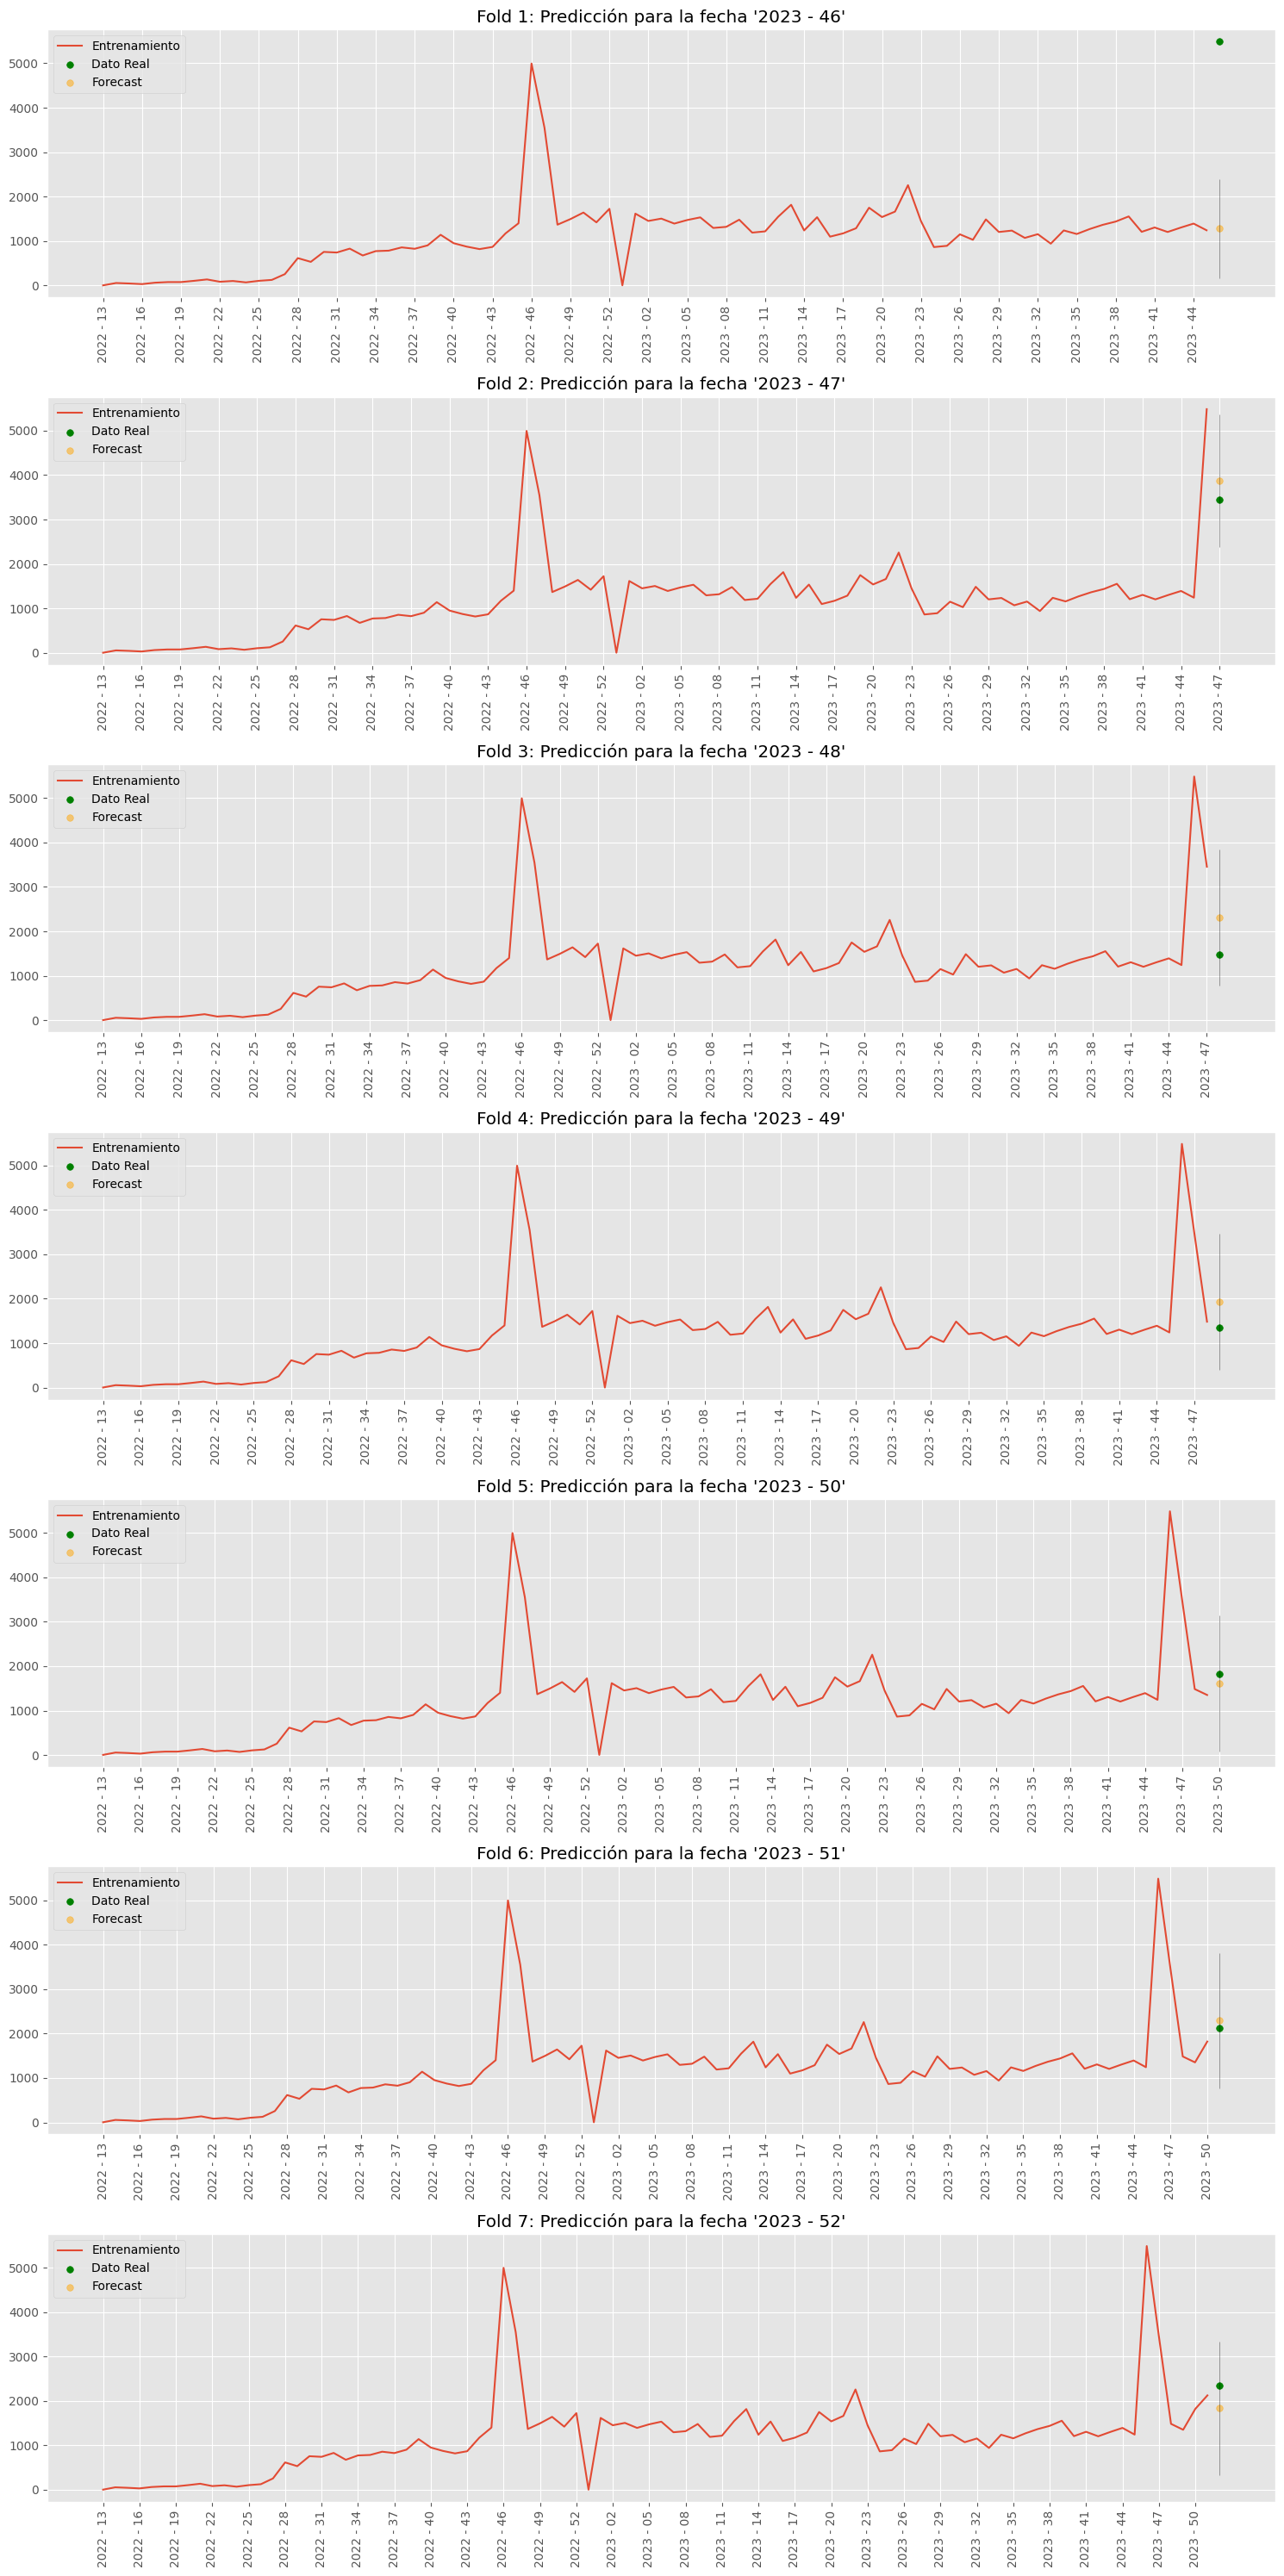

In [219]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
import warnings

warnings.filterwarnings("ignore")

tss = TimeSeriesSplit(n_splits = 7, test_size=1) 

differenced_orders = df2
X = differenced_orders.index.values # Ya se encuentra todo ordenado por fecha
Y = differenced_orders.values

metrics = {"MAPE": [], 
          "MSE": []}

fig, axs = plt.subplots(7, figsize=(15, 30))

for i, (train_index, test_index) in enumerate(tss.split(X)):
    
    # Datos de entrenamiento y test

    X_train = differenced_orders.iloc[train_index]
    Y_test = differenced_orders.iloc[test_index]

    # Generación modelo ARIMA, los indíces en el formato de fecha, dado que son semanas no los interpreta bien, por lo tanto se pasan como enteros
    # consevutivos (1,2,3,4..)

    model = ARIMA(X_train.reset_index(drop=True), order=(7, 1, 6)) #Definir valores de ARIMA
    model_fit = model.fit()
    forecastedValues = model_fit.forecast()
    pred_wrapper = model_fit.get_forecast() # Obtener wrapper de forecast
    df_forecast_intervals = pred_wrapper.conf_int(alpha = 0.05) # Obtener confidence intervals del forecast (Lower y upper limits); es un dataframe la variable

    # Valores predichos guardados en serie de pandas para poder usarlos en gráficas y 

    forecastSeries = pd.Series(np.array(forecastedValues), index = Y_test.index.values)

    metrics["MAPE"].append(mean_absolute_percentage_error(Y_test.values, np.array(forecastedValues)))
    metrics["MSE"].append(mean_squared_error(Y_test.values, np.array(forecastedValues)))


    axs[i].plot(X_train, label='Entrenamiento') #Plot de datos de entrenamiento
    axs[i].scatter(Y_test.index, Y_test, color='green', label='Dato Real', s=30) # Plot datos de test
    axs[i].scatter(forecastSeries.index, forecastSeries, color='orange', label='Forecast', s=30,  alpha=0.5) # Plot datos de forecast
    axs[i].fill_between(forecastSeries.index,
                df_forecast_intervals.iloc[:, 0],
                df_forecast_intervals.iloc[:, 1], color='black', alpha=0.5)

    # Modificación de atributos para mostrar en plots
    axs[i].set_title(f"Fold {i+1}: Predicción para la fecha '{Y_test.index.values[0]}'")
    axs[i].tick_params(axis='x', rotation=90)
    axs[i].set_xticks(axs[i].get_xticks()[::3])
    axs[i].legend(loc='upper left')

plt.tight_layout() 
plt.show()

## Predictions' errors

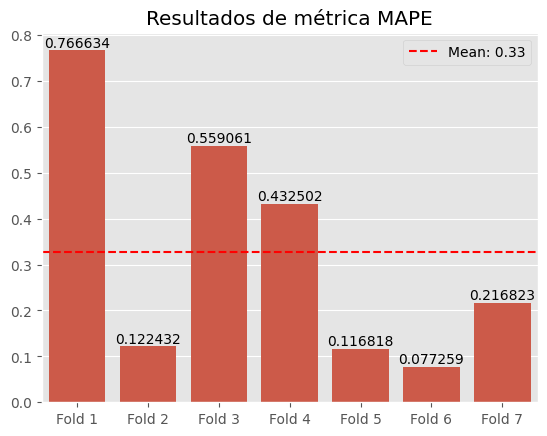

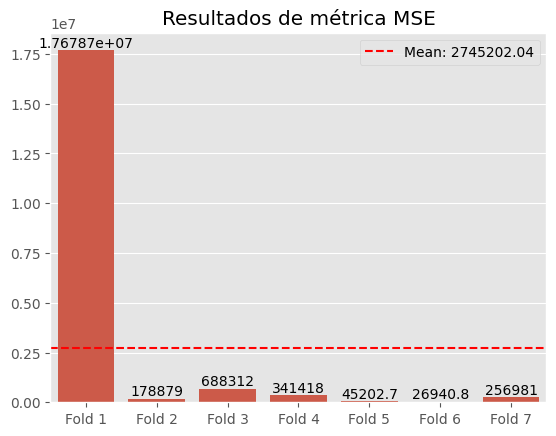

In [220]:
for keys, value in metrics.items():
    labels = [f"Fold {i}" for i in range(1, 8)]
    ax = sns.barplot(np.abs(value))
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels)
    ax.bar_label(ax.containers[0])

    # Dibujar la línea horizontal para la media
    mean_value = np.mean(np.abs(value))
    plt.axhline(mean_value, color='r', linestyle='--', label=f"Mean: {mean_value:.2f}")

    plt.title(f"Resultados de métrica {keys}")  
    plt.legend()  # Mostrar la leyenda con el nombre y el valor de la media
    plt.show()


## Cross validation (5% de datos como test)

Número de datos de testeo que corresponden al 20% es de: 19
Número de datos de testeo que corresponden al resto de datos: 74


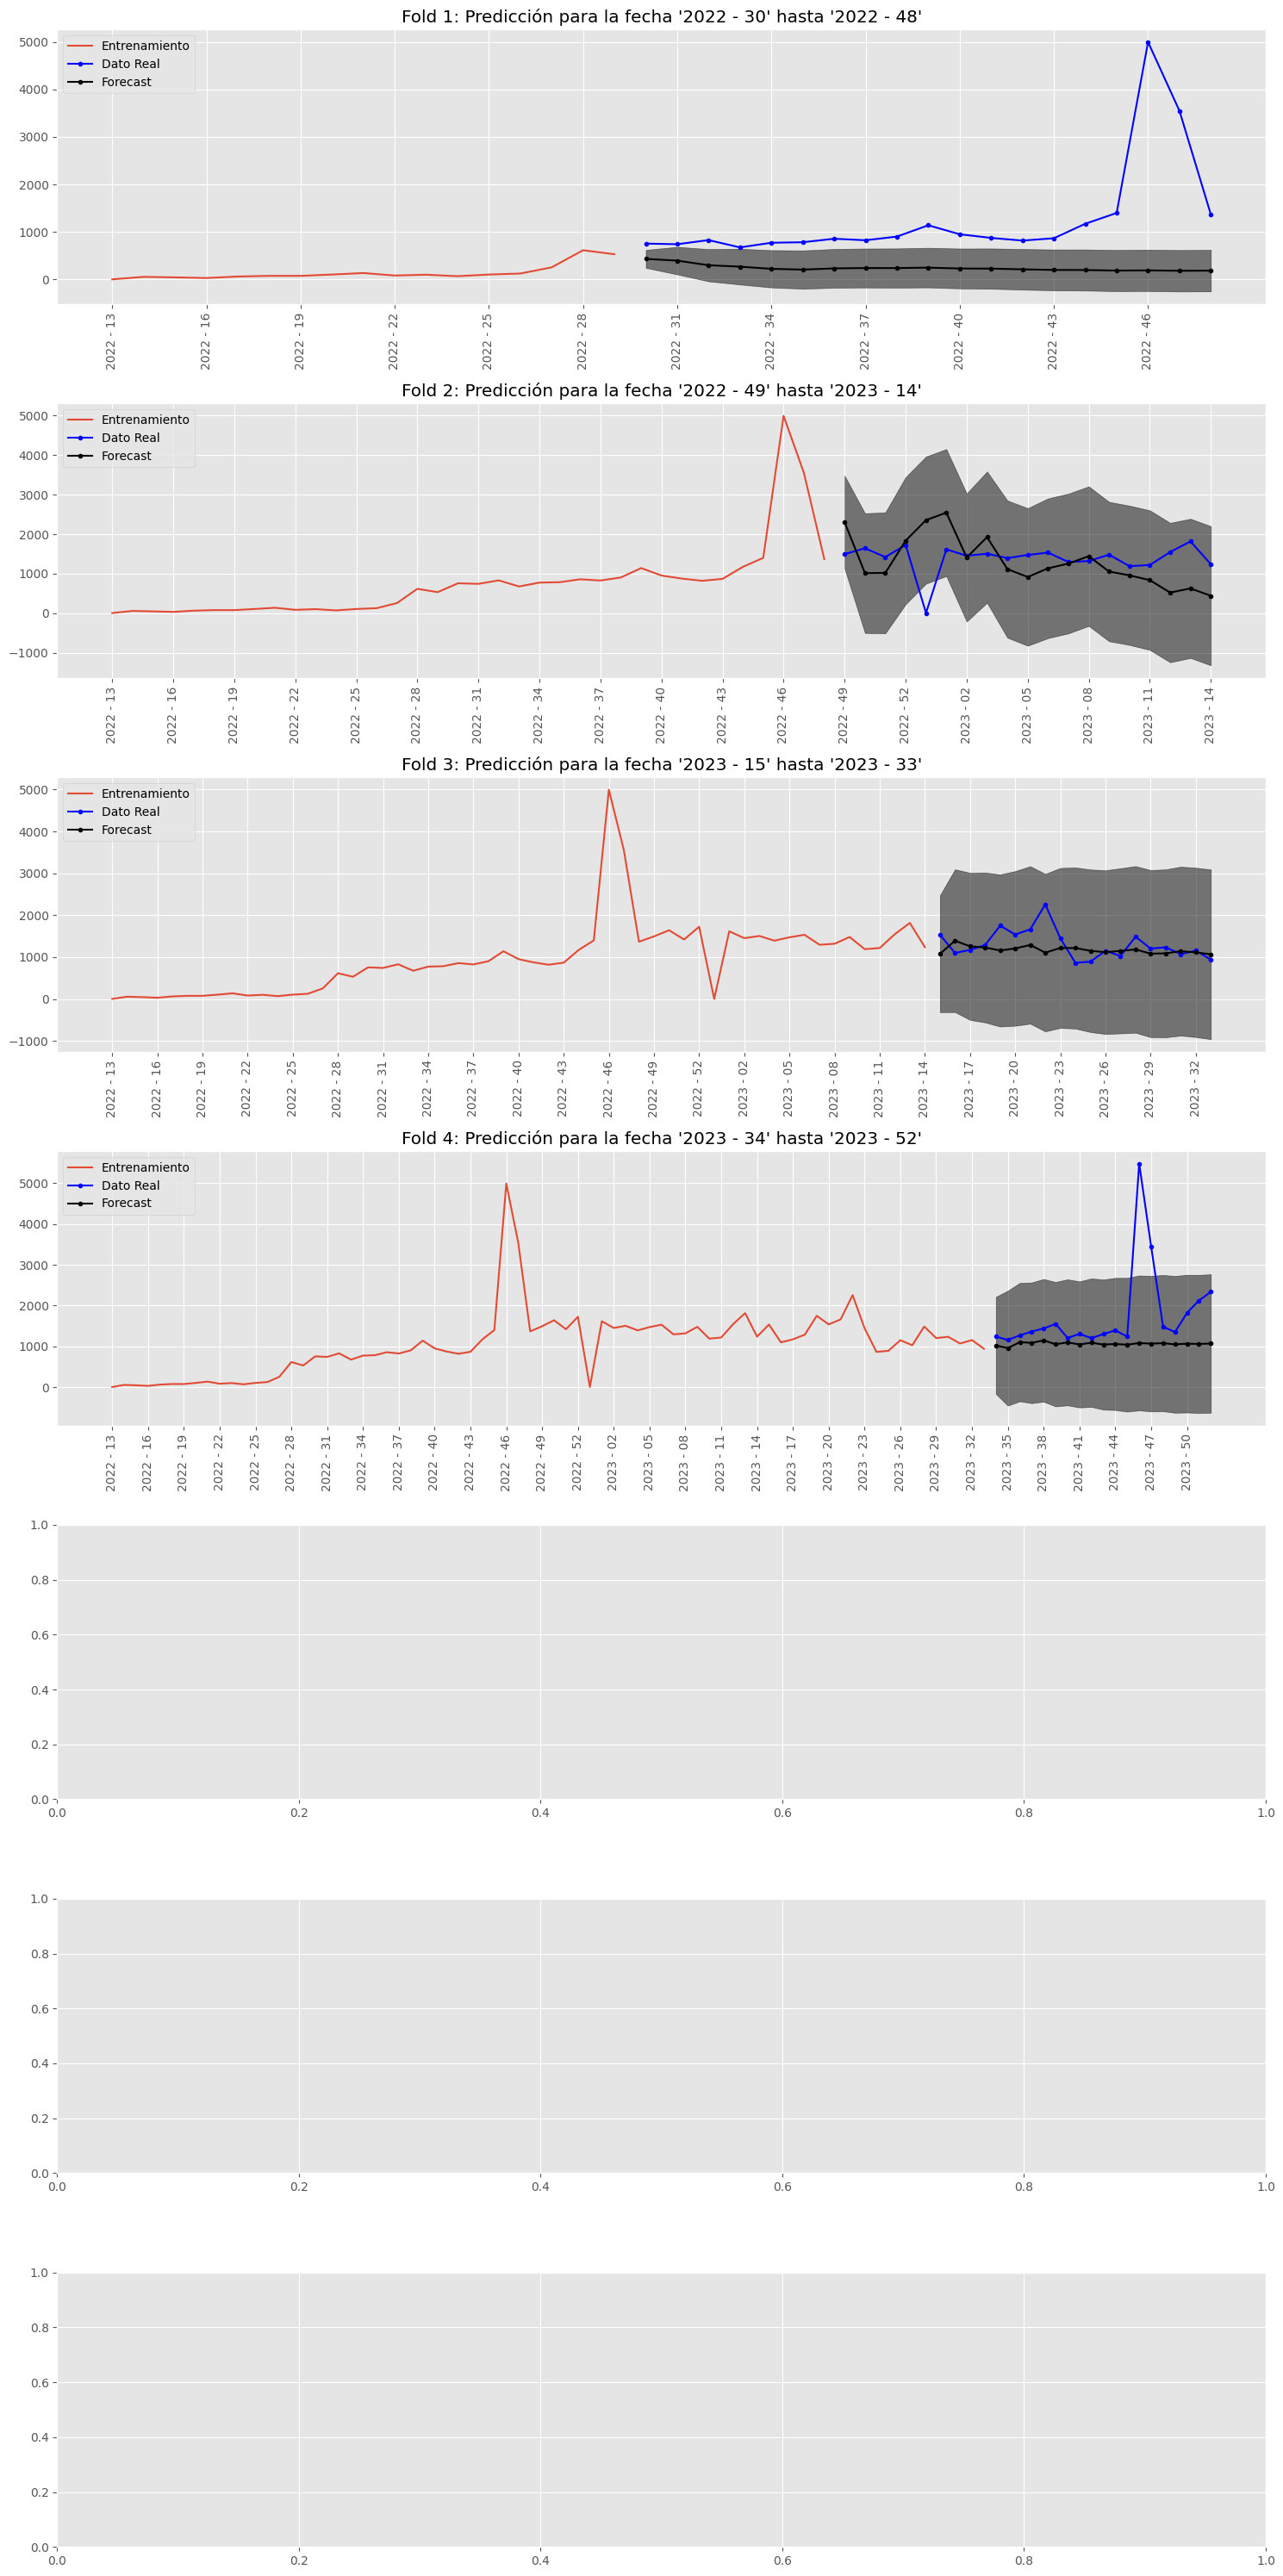

In [221]:
warnings.filterwarnings("ignore")

PorcentajeDatosTesteo = 0.2
datosTesteo = round(len(differenced_orders)*PorcentajeDatosTesteo)
print(f"Número de datos de testeo que corresponden al {round(PorcentajeDatosTesteo*100)}% es de: {datosTesteo}")
print(f"Número de datos de testeo que corresponden al resto de datos: {round(len(differenced_orders)*(1-PorcentajeDatosTesteo))}")

tss = TimeSeriesSplit(n_splits = 4, test_size = round(len(differenced_orders)*PorcentajeDatosTesteo))

differenced_orders = df2
X = differenced_orders.index.values # Ya se encuentra todo ordenado por fecha
Y = differenced_orders.values

absolute_errors_list = []

fig, axs = plt.subplots(7, figsize=(15, 30))

MAPE = []
MSE = []

for i, (train_index, test_index) in enumerate(tss.split(X)):
    
   # Datos de entrenamiento y test

    X_train = differenced_orders.iloc[train_index]
    Y_test = differenced_orders.iloc[test_index]

    # Generación modelo ARIMA, los indíces en el formato de fecha, dado que son semanas no los interpreta bien, por lo tanto se pasan como enteros
    # consevutivos (1,2,3,4..)

    model = ARIMA(X_train.reset_index(drop=True), order=(12, 0, 5)) #Definir valores de ARIMA
    model_fit = model.fit()
    forecastedValues = model_fit.forecast(datosTesteo) #Hace un forecast de la cantidad de datos especificada
    pred_wrapper = model_fit.get_forecast(datosTesteo) # Obtener wrapper de forecast
    df_forecast_intervals = pred_wrapper.conf_int(alpha = 0.05) # Obtener confidence intervals del forecast (Lower y upper limits); es un dataframe la variable

    # Valores predichos guardados en serie de pandas para poder usarlos en gráficas y 

    forecastSeries = pd.Series(np.array(forecastedValues), index = Y_test.index.values)
    
    MAPE.append(mean_absolute_percentage_error(Y_test.values, np.array(forecastedValues)))
    MSE.append(mean_squared_error(Y_test.values, np.array(forecastedValues)))

    axs[i].plot(X_train, label='Entrenamiento') #Plot de datos de entrenamiento
    axs[i].plot(Y_test, color='blue', markersize = 3, marker = "o", label='Dato Real') # Plot datos de test
    axs[i].plot(forecastSeries, color='black', markersize = 3, marker = "o", label='Forecast') # Plot datos de forecast
    axs[i].fill_between(forecastSeries.index,
                df_forecast_intervals.iloc[:, 0],
                df_forecast_intervals.iloc[:, 1], color='black', alpha=0.5)

    # Modificación de atributos para mostrar en plots
    axs[i].set_title(f"Fold {i+1}: Predicción para la fecha '{Y_test.index.values[0]}' hasta '{Y_test.index.values[-1]}'")
    axs[i].tick_params(axis='x', rotation=90)
    axs[i].set_xticks(axs[i].get_xticks()[::3])
    axs[i].legend(loc='upper left')

plt.tight_layout() 
plt.show()

## Predictions' errors

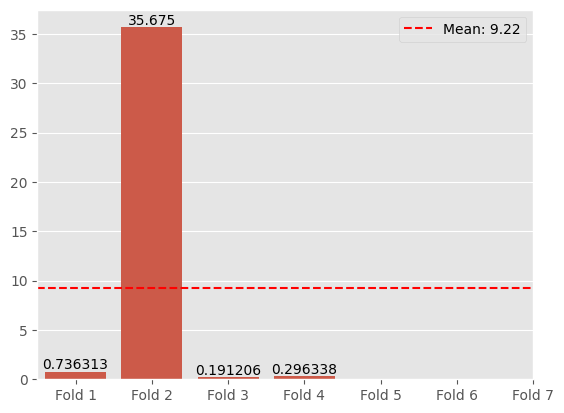

In [222]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

labels = [f"Fold {i}" for i in range(1, 8)]
ax = sns.barplot(MAPE) # Obtiene la media de los errores
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)
ax.bar_label(ax.containers[0])

# Dibujar la línea horizontal para la media
mean_value = np.mean(MAPE)
plt.axhline(mean_value, color='r', linestyle='--', label=f"Mean: {mean_value:.2f}") # Genera una línea que indica la media de los errores en cada fold

plt.legend()  # Mostrar la leyenda con el nombre y el valor de la media
plt.show()


<Axes: >

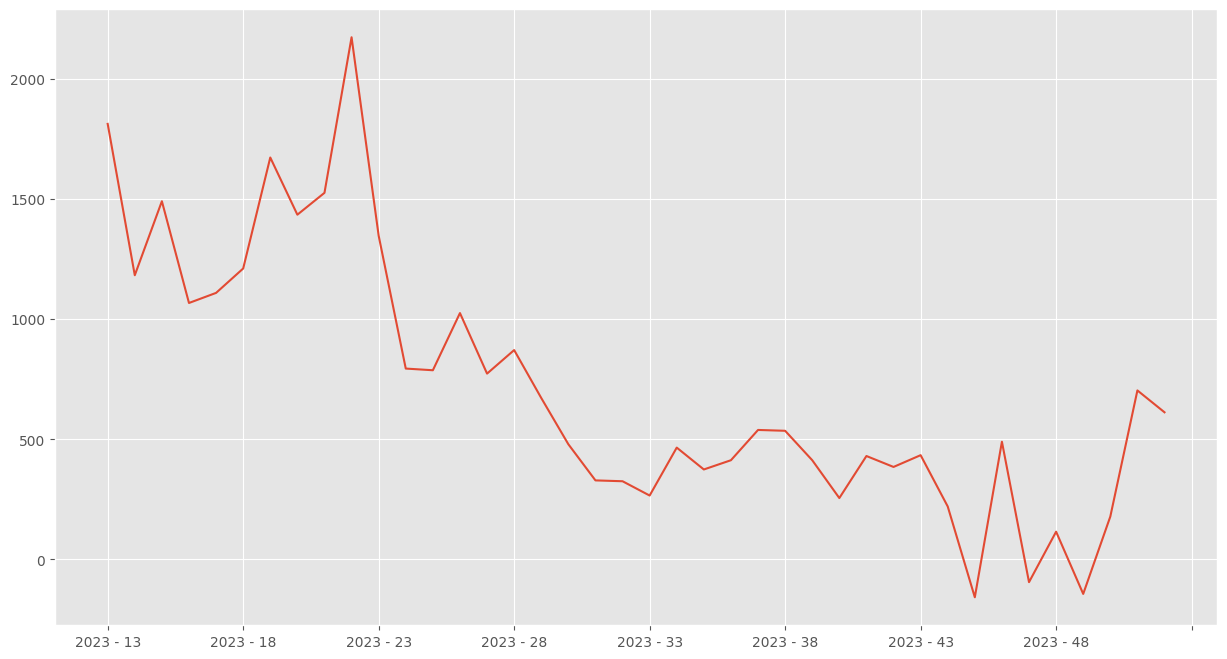

In [223]:
fig, ax = plt.subplots(figsize=(15, 8))

df3 = pd.DataFrame(df2.reset_index(drop=True))
df3["Shift"] = df3.shift(53)
df3.dropna(inplace = True)
df3 = df3["Suma Total"] - df3["Shift"]
df3.index = df2.index.values[53:]

df4 = pd.DataFrame(df3.reset_index(drop=True), columns=["Suma Total"])
df4["Shift"] = df4.shift(1)
df4.dropna(inplace = True)
df4 = df4["Suma Total"] - df4["Shift"]

df5 = df4.copy()
df5.index = df3.index.values[1:]
df3.plot()

In [224]:
# Dividir los datos
split_index = int(0.8 * len(df3))
train_data = df3.iloc[:split_index]
test_data = df3.iloc[split_index:]

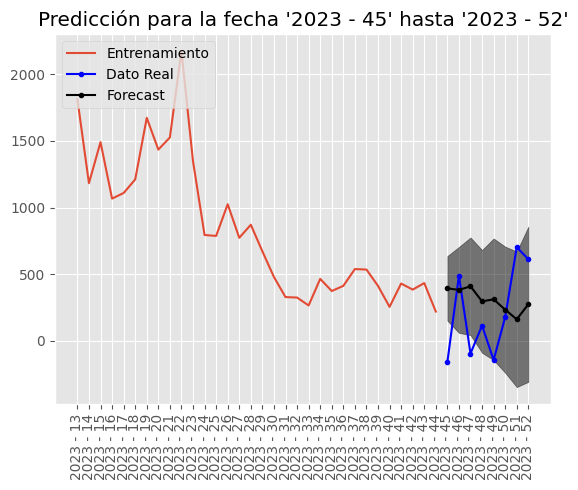

In [225]:

model = ARIMA(train_data.reset_index(drop=True), order=(8, 1, 4))
model_fit = model.fit()

metrics = {"MAPE": [], 
          "MSE": []}

# Realizar la predicción
forecastedValues = model_fit.forecast(len(test_data))

# Obtener intervalos de confianza
pred_wrapper = model_fit.get_forecast(len(test_data))
df_forecast_intervals = pred_wrapper.conf_int(alpha=0.05)

# Crear una serie de pandas para los valores pronosticados
forecastSeries = pd.Series(np.array(forecastedValues), index=test_data.index)

# Calcular errores de predicción
metrics["MAPE"].append(mean_absolute_percentage_error(test_data.values, np.array(forecastedValues)))
metrics["MSE"].append(mean_squared_error(test_data.values, np.array(forecastedValues)))

# Plotear los resultados
plt.plot(train_data, label='Entrenamiento')
plt.plot(test_data, color='blue', markersize=3, marker="o", label='Dato Real')
plt.plot(forecastSeries, color='black', markersize=3, marker="o", label='Forecast')
plt.fill_between(forecastSeries.index, df_forecast_intervals.iloc[:, 0], df_forecast_intervals.iloc[:, 1], color='black', alpha=0.5)

# Modificar atributos para mostrar en plots
plt.title(f"Predicción para la fecha '{test_data.index.values[0]}' hasta '{test_data.index.values[-1]}'")
plt.xticks(rotation=90)
plt.legend(loc='upper left')
plt.show()

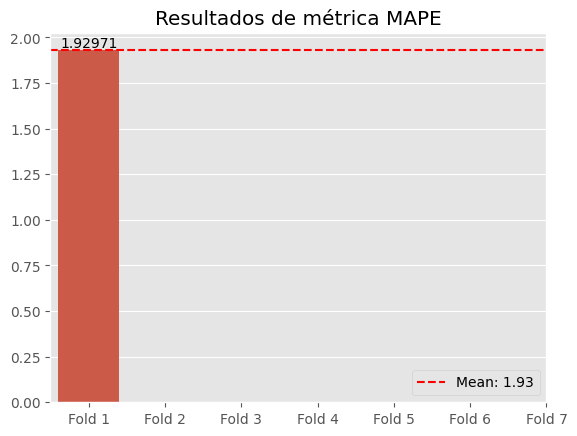

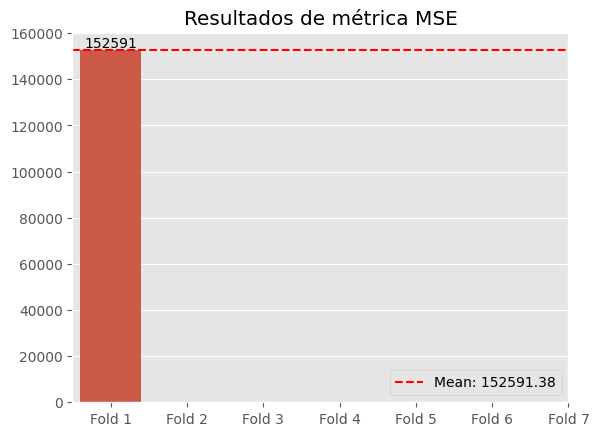

In [226]:
for keys, value in metrics.items():
    labels = [f"Fold {i}" for i in range(1, 8)]
    ax = sns.barplot(np.abs(value))
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels)
    ax.bar_label(ax.containers[0])

    # Dibujar la línea horizontal para la media
    mean_value = np.mean(np.abs(value))
    plt.axhline(mean_value, color='r', linestyle='--', label=f"Mean: {mean_value:.2f}")

    plt.title(f"Resultados de métrica {keys}")  
    plt.legend()  # Mostrar la leyenda con el nombre y el valor de la media
    plt.show()

In [227]:
df3 = df.copy()
df3.query("`Encoded Products` == 'Producto 273'", inplace=True)
df3.drop(columns="Encoded Products", inplace = True)
df3 = df3.groupby("date", as_index=False)["Suma Total"].sum()
full_dates = pd.DataFrame(pd.date_range(start=df3["date"].min(), end=df3["date"].max()), columns = ["date"]) # Se crea una serie de panads donde contenga todas las fechas 
# (de cada día) del producto 273, aun cuando no se haya vendido en ciertos días, esto con el propósito de tener uniformidad en fechas

merged_df = pd.merge(full_dates, df3, on='date', how='left')
merged_df.fillna({"Suma Total":0}, inplace=True)
merged_df.set_index("date", inplace = True)

merged_df.sort_values(by = "Suma Total", ascending=False).iloc[:10]

Suma Total
date                  
2023-11-20      2303.0
2022-11-21      2194.5
2023-11-18      1697.5
2023-11-19      1683.5
2022-11-20      1526.0
2022-11-19      1410.5
2023-11-17       801.5
2022-11-18       717.5
2023-06-03       514.5
2023-12-30       507.5

<Axes: xlabel='date'>

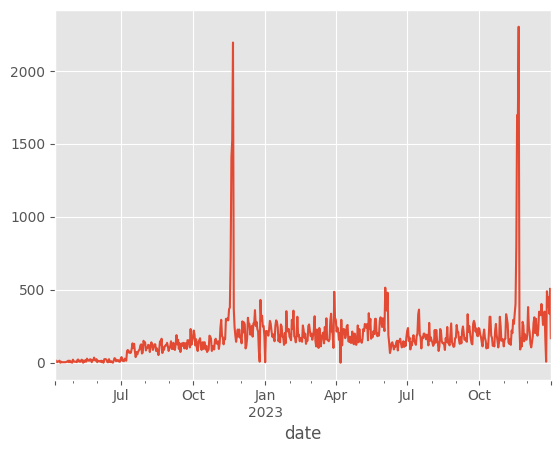

In [228]:
df3 = df.copy()
df3.query("`Encoded Products` == 'Producto 273'", inplace=True)
df3.drop(columns="Encoded Products", inplace = True)
df3 = df3.groupby("date", as_index=False)["Suma Total"].sum()
full_dates = pd.DataFrame(pd.date_range(start=df3["date"].min(), end=df3["date"].max()), columns = ["date"]) # Se crea una serie de panads donde contenga todas las fechas (de cada día)
# del producto 273, aun cuando no se haya vendido en ciertos días, esto con el propósito de tener uniformidad en fechas
merged_df = pd.merge(full_dates, df3, on='date', how='left')
merged_df.fillna({"Suma Total":0}, inplace=True)
merged_df.set_index("date", inplace = True)

merged_df["shift"] = merged_df.shift(7)
merged_df.dropna(inplace = True)
merged_df["difference"] = merged_df["Suma Total"] - merged_df["shift"]
merged_df["Suma Total"].plot()

# Redes Neuronales LSTM

## Producto 273 por días

Importación de librerías

In [229]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import keras
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

Preparación de datos

In [230]:
#Creación de df
df_LSTM_diario = df.copy()
df_LSTM_diario.query("`Encoded Products` == 'Producto 273'", inplace=True)
df_LSTM_diario.drop(columns="Encoded Products", inplace = True)
df_LSTM_diario = df_LSTM_diario.groupby("date", as_index=False)["Suma Total"].sum()
full_dates = pd.DataFrame(pd.date_range(start=df_LSTM_diario["date"].min(), end=df_LSTM_diario["date"].max()), columns = ["date"]) 

merged_df = pd.merge(full_dates, df_LSTM_diario, on='date', how='left')
merged_df.fillna({"Suma Total":0}, inplace=True)

merged_df.set_index("date", inplace = True)

serie_tiempo = merged_df

In [231]:
scaler = MinMaxScaler(feature_range=(0, 1))
datos_normalizados = scaler.fit_transform(serie_tiempo[['Suma Total']].values)

In [232]:
# Preparación de los datos para LSTM
def preparar_datos(datos, pasos):
    X, Y = [], []
    for i in range(len(datos) - pasos):
        fin_seq = i + pasos
        secuencia = datos[i:fin_seq, :]
        X.append(secuencia)
        Y.append(datos[fin_seq, 0])
    return np.array(X), np.array(Y)

pasos = 5
X, Y = preparar_datos(datos_normalizados, pasos)

In [233]:
# Dividir los datos en entrenamiento y prueba usando shuffle false para que sean secuenciales
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=False)

X_train = X_train.reshape((X_train.shape[0], pasos, 1))
X_test = X_test.reshape((X_test.shape[0], pasos, 1))

X_train.shape, X_test.shape

((508, 5, 1), (127, 5, 1))

Creación del modelo LSTM


In [234]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=10)
epochs = 300
batch_size=16
learn_rate = 0.001
optimizer = keras.optimizers.Adam(learning_rate=learn_rate)

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', metrics=["mape","mse"], optimizer=optimizer)

Entrenamiento del modelo


In [357]:
Historia1 = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=False, callbacks=[callback], validation_data=(X_test, y_test))

Epoch 1/300
1/4 [======>.......................] - ETA: 0s - loss: 3.4127e-04 - mape: 913853.2500 - mse: 3.4127e-04

4/4 [==============================] - 0s 40ms/step - loss: 0.0013 - mape: 399906.1875 - mse: 0.0013 - val_loss: 0.0071 - val_mape: 54.2581 - val_mse: 0.0071
Epoch 2/300
4/4 [==============================] - 0s 27ms/step - loss: 0.0014 - mape: 349737.9688 - mse: 0.0014 - val_loss: 0.0070 - val_mape: 52.0713 - val_mse: 0.0070
Epoch 3/300
4/4 [==============================] - 0s 21ms/step - loss: 0.0013 - mape: 310778.5938 - mse: 0.0013 - val_loss: 0.0066 - val_mape: 51.1735 - val_mse: 0.0066
Epoch 4/300
4/4 [==============================] - 0s 16ms/step - loss: 0.0013 - mape: 293279.0938 - mse: 0.0013 - val_loss: 0.0060 - val_mape: 51.2417 - val_mse: 0.0060
Epoch 5/300
4/4 [==============================] - 0s 16ms/step - loss: 0.0012 - mape: 296313.2812 - mse: 0.0012 - val_loss: 0.0054 - val_mape: 51.9425 - val_mse: 0.0054
Epoch 6/300
4/4 [==============================] - 0s 18ms/step - loss: 0.0011 - mape: 311968.7500 - mse: 0.0011 - val_loss: 0.0049 - val_mape: 52.8725 - val_mse:

Predicciones y evaluación

In [358]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

import numpy as np

predicciones = model.predict(X_test)

# Desnormalizar las predicciones 
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
predicciones_inv = scaler.inverse_transform(predicciones.reshape(-1, 1))

# Calcular MSE
mse = mean_squared_error(y_test_inv, predicciones_inv)
# Calcular RMSE
rmse = np.sqrt(mse)
# Calcular MAE
mae = mean_absolute_error(y_test_inv, predicciones_inv)
# Calcular R^2
r2 = r2_score(y_test_inv, predicciones_inv)
# Calcular MAPE
mape = mean_absolute_percentage_error(y_test_inv, predicciones_inv)

indicators_df_train = pd.DataFrame({
    'MSE': [mse],
    'MAPE': [mape],
    'RMSE': [rmse],
    'MAE': [mae],
    'R^2': [r2],
})

indicators_df_train

4/4 [==============================] - 0s 2ms/step


MSE      MAPE       RMSE        MAE       R^2
0  2610.789784  0.319586  51.095888  30.516362  0.772721

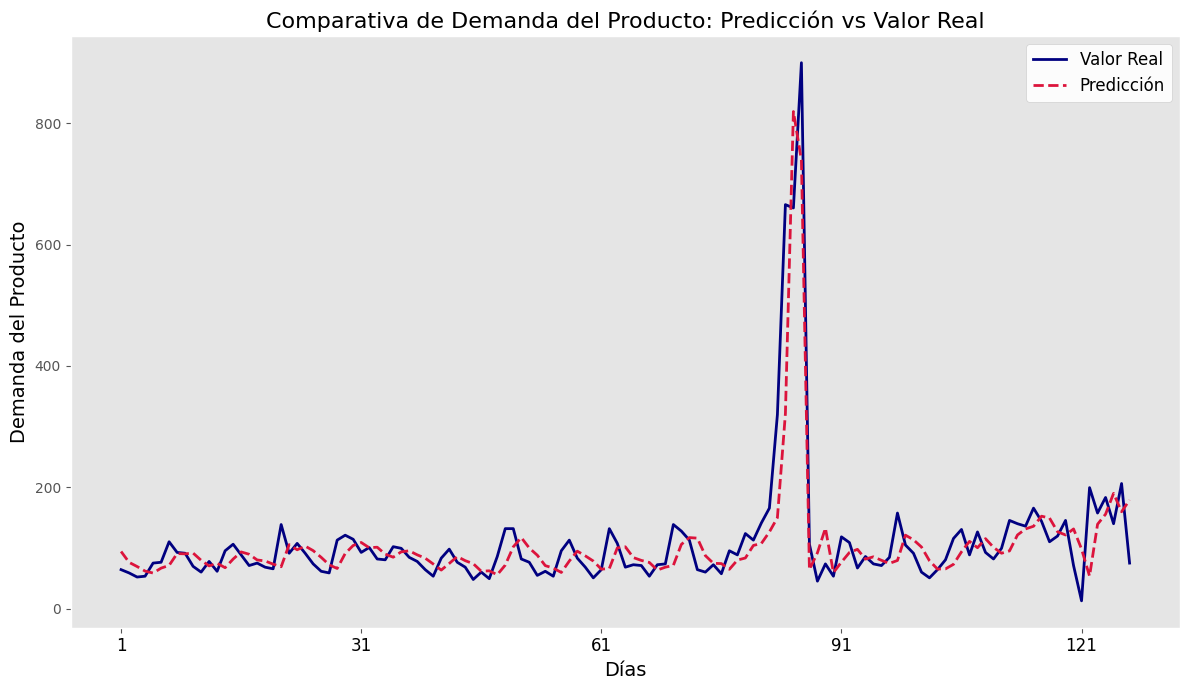

In [359]:
import matplotlib.pyplot as plt

numero_de_dias = X_test.shape[0]
dias = np.arange(1, numero_de_dias + 1)

plt.figure(figsize=(12, 7))
plt.grid(False)
plt.xticks(np.arange(min(dias), max(dias)+1, 30), fontsize=12, color='black') 
plt.plot(dias, y_test_inv, label='Valor Real', color='navy', linewidth=2, markersize=8)
plt.plot(dias, predicciones_inv, label='Predicción', color='crimson', linestyle='--', linewidth=2, markersize=8)

plt.legend(frameon=False, fontsize=12)
plt.title('Comparativa de Demanda del Producto: Predicción vs Valor Real', fontsize=16)
plt.xlabel('Días', fontsize=14, color='black')
plt.ylabel('Demanda del Producto', fontsize=14, color='black')
plt.legend(frameon=True, facecolor='white', framealpha=0.9, fontsize=12)

plt.tight_layout()
plt.show()

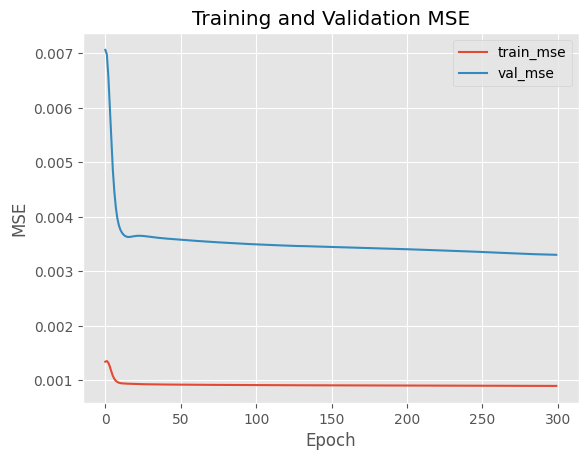

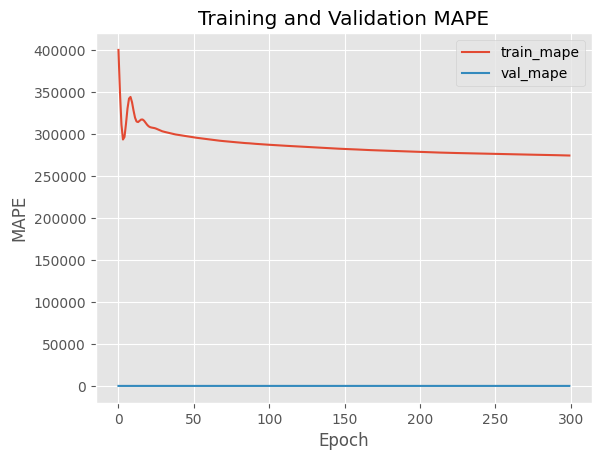

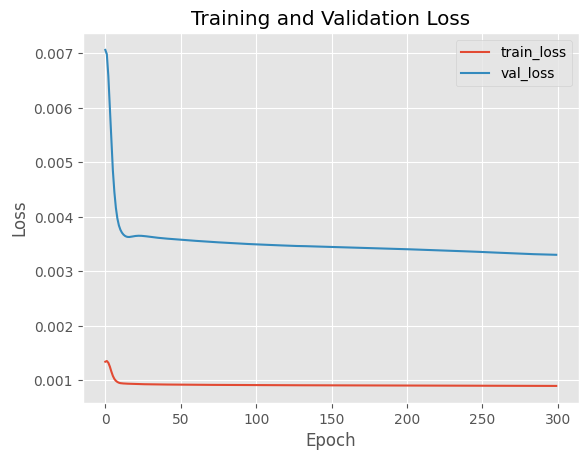

In [360]:
epochs_realizadas = len(Historia1.history['loss']) 
plt.style.use("ggplot")

# MSE
plt.figure()
plt.plot(np.arange(0, epochs_realizadas), Historia1.history["mse"], label="train_mse")
plt.plot(np.arange(0, epochs_realizadas), Historia1.history["val_mse"], label="val_mse")
plt.title("Training and Validation MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()

# MAPE
plt.figure()
plt.plot(np.arange(0, epochs_realizadas), Historia1.history["mape"], label="train_mape")
plt.plot(np.arange(0, epochs_realizadas), Historia1.history["val_mape"], label="val_mape")
plt.title("Training and Validation MAPE")
plt.xlabel("Epoch")
plt.ylabel("MAPE")
plt.legend()

# Loss
plt.figure()
plt.plot(np.arange(0, epochs_realizadas), Historia1.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs_realizadas), Historia1.history["val_loss"], label="val_loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


## Producto 273 por semana

Preparación de datos

In [250]:
# Asegurarse de que 'date' esté en formato datetime
df['date'] = pd.to_datetime(df['date'], format='%d %b %Y')

# Filtrar por 'Producto 273'
df_producto = df.query("`Encoded Products` == 'Producto 273'")
df_producto = df_producto.drop(columns="Encoded Products")

# Asegurarse de que 'date' es el índice
df_producto.set_index('date', inplace=True)

# Agrupar por semana y sumar los totales semanales
df_semanal = df_producto.resample('W').sum()

df_semanal.reset_index(inplace=True)
print(df_semanal)

         date  Suma Total
0  2022-04-03         3.5
1  2022-04-10        56.0
2  2022-04-17        45.5
3  2022-04-24        31.5
4  2022-05-01        63.0
..        ...         ...
87 2023-12-03      1484.0
88 2023-12-10      1351.0
89 2023-12-17      1820.0
90 2023-12-24      2124.5
91 2023-12-31      2338.0

[92 rows x 2 columns]


In [251]:
serie_tiempo2 = df_semanal

In [252]:
datos_normalizados2 = scaler.fit_transform(serie_tiempo2[['Suma Total']].values)

In [253]:
def preparar_datos(datos, pasos):
    X, Y = [], []
    for i in range(len(datos) - pasos):
        fin_seq = i + pasos
        secuencia = datos[i:fin_seq, :]
        X.append(secuencia)
        Y.append(datos[fin_seq, 0])
    return np.array(X), np.array(Y)

pasos = 2
X2, Y2 = preparar_datos(datos_normalizados2, pasos)
print(X2.shape)

(90, 2, 1)


In [254]:
# Dividir los datos en entrenamiento y prueba usando shuffle false para que sean secuenciales
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, Y2, test_size=0.05, random_state=42, shuffle=False)

X_train2 = X_train2.reshape((X_train2.shape[0], pasos, 1))
X_test2 = X_test2.reshape((X_test2.shape[0], pasos, 1))

X_train2.shape, X_test2.shape

((85, 2, 1), (5, 2, 1))

Creación del modelo

In [255]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=10)
epochs = 500
batch_size=16
learn_rate = 0.0001
optimizer = keras.optimizers.Adam(learning_rate=learn_rate)

model2 = Sequential()
model2.add(LSTM(200, activation='relu', input_shape=(X_train2.shape[1], X_train2.shape[2]), return_sequences=True))
model2.add(LSTM(200))
model2.add(Dense(1))
model2.compile(loss='mse', metrics=["mape","mse"], optimizer=optimizer)

Entrenamiento del modelo

In [341]:
Historia = model2.fit(X_train2, y_train2, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=False, callbacks=[callback],validation_data=(X_test2, y_test2)) 

Epoch 1/300
1/1 [==============================] - ETA: 0s - loss: 0.0213 - mape: 230.2582 - mse: 0.0213

1/1 [==============================] - 1s 710ms/step - loss: 0.0213 - mape: 230.2582 - mse: 0.0213 - val_loss: 0.0168 - val_mape: 38.9039 - val_mse: 0.0168
Epoch 2/300
1/1 [==============================] - 0s 54ms/step - loss: 0.0214 - mape: 230.5769 - mse: 0.0214 - val_loss: 0.0169 - val_mape: 38.9538 - val_mse: 0.0169
Epoch 3/300
1/1 [==============================] - 0s 54ms/step - loss: 0.0214 - mape: 230.7180 - mse: 0.0214 - val_loss: 0.0169 - val_mape: 38.9939 - val_mse: 0.0169
Epoch 4/300
1/1 [==============================] - 0s 63ms/step - loss: 0.0214 - mape: 230.6960 - mse: 0.0214 - val_loss: 0.0169 - val_mape: 39.0251 - val_mse: 0.0169
Epoch 5/300
1/1 [==============================] - 0s 77ms/step - loss: 0.0213 - mape: 230.5255 - mse: 0.0213 - val_loss: 0.0169 - val_mape: 39.0484 - val_mse: 0.0169
Epoch 6/300
1/1 [==============================] - 0s 65ms/step - loss: 0.0213 - mape: 230.2198 - mse: 0.0213 - val_loss: 0.0170 - val_mape: 39.0646 - val_mse: 0.0170
Epoch 7/3

Predicciones y evaluación 

In [355]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

import numpy as np

predicciones2 = model.predict(X_test2)

# Desnormalizar las predicciones y las etiquetas verdaderas para calcular las métricas en la escala original
y_test_inv2 = scaler.inverse_transform(y_test2.reshape(-1, 1))
predicciones_inv2 = scaler.inverse_transform(predicciones2.reshape(-1, 1))

# Calcular MSE
mse = mean_squared_error(y_test_inv2, predicciones_inv2)
# Calcular RMSE
rmse = np.sqrt(mse)
# Calcular MAE
mae = mean_absolute_error(y_test_inv2, predicciones_inv2)
# Calcular R^2
r2 = r2_score(y_test_inv2, predicciones_inv2)
# Calcular MAPE
mape = mean_absolute_percentage_error(y_test_inv2, predicciones_inv2)

indicators_df_train = pd.DataFrame({
    'MSE': [mse],
    'MAPE': [mape],
    'RMSE': [rmse],
    'MAE': [mae],
    'R^2': [r2],
})

indicators_df_train

1/1 [==============================] - 0s 26ms/step


MSE      MAPE      RMSE       MAE       R^2
0  66.071159  0.026712  8.128417  7.296966  0.981902

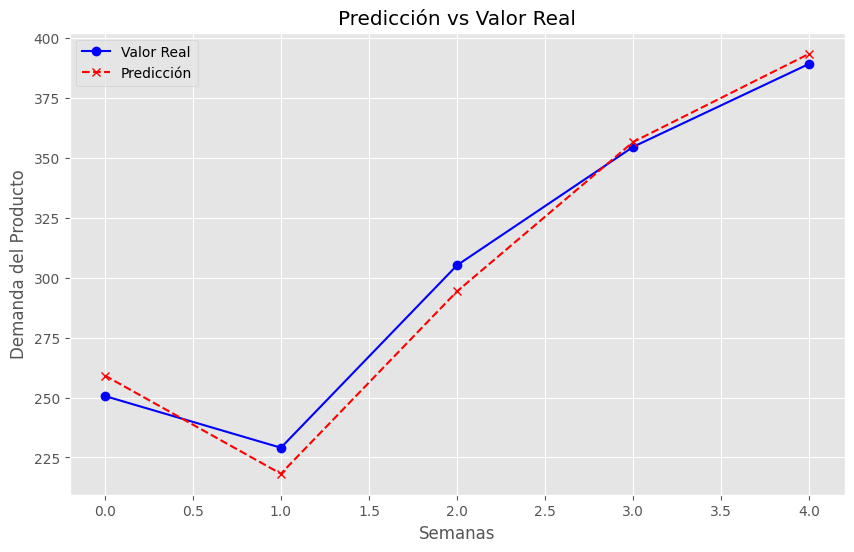

In [356]:
import matplotlib.pyplot as plt

# Graficar las predicciones vs los valores reales
plt.figure(figsize=(10,6))
plt.plot(y_test_inv2, label='Valor Real', color='blue', marker='o')
plt.plot(predicciones_inv2, label='Predicción', color='red', linestyle='--', marker='x')
plt.title('Predicción vs Valor Real')
plt.xlabel('Semanas')
plt.ylabel('Demanda del Producto')
plt.legend()
plt.show()


In [344]:
print(Historia.history.keys())


dict_keys(['loss', 'mape', 'mse', 'val_loss', 'val_mape', 'val_mse'])


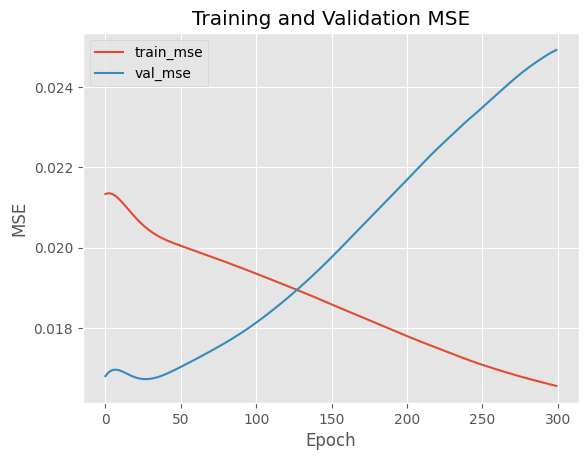

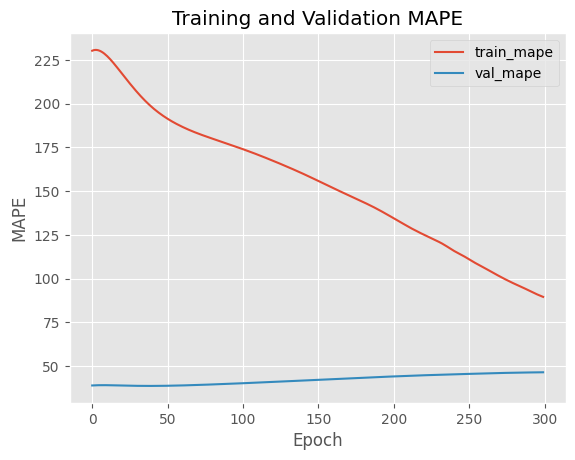

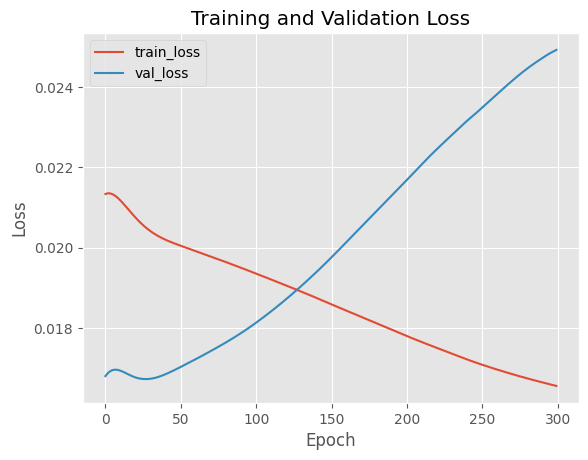

In [345]:
epochs_realizadas = len(Historia.history['loss']) 

plt.style.use("ggplot")

# MSE
plt.figure()
plt.plot(np.arange(0, epochs_realizadas), Historia.history["mse"], label="train_mse")
plt.plot(np.arange(0, epochs_realizadas), Historia.history["val_mse"], label="val_mse")
plt.title("Training and Validation MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()

# MAPE
plt.figure()
plt.plot(np.arange(0, epochs_realizadas), Historia.history["mape"], label="train_mape")
plt.plot(np.arange(0, epochs_realizadas), Historia.history["val_mape"], label="val_mape")
plt.title("Training and Validation MAPE")
plt.xlabel("Epoch")
plt.ylabel("MAPE")
plt.legend()

# Loss
plt.figure()
plt.plot(np.arange(0, epochs_realizadas), Historia.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs_realizadas), Historia.history["val_loss"], label="val_loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


## Semanal Producto top 2-5

Preparación de datos

In [370]:
# Asegurarse de que 'date' esté en formato datetime
df['date'] = pd.to_datetime(df['date'], format='%d %b %Y')

# Filtrar por 'Producto 1'
df_producto3 = df.query("`Encoded Products` == 'Producto 1'")

df_producto3 = df_producto3.drop(columns="Encoded Products")

# Asegurarse de que 'date' es el índice
df_producto3.set_index('date', inplace=True)

# Agrupar por semana y sumar los totales semanales
df_semanal3 = df_producto3.resample('W').sum()

df_semanal3.reset_index(inplace=True)
print(df_semanal3)

          date  Suma Total
0   2022-01-02        35.0
1   2022-01-09       213.5
2   2022-01-16       623.0
3   2022-01-23       899.5
4   2022-01-30       644.0
..         ...         ...
100 2023-12-03       189.0
101 2023-12-10       178.5
102 2023-12-17       133.0
103 2023-12-24       199.5
104 2023-12-31       150.5

[105 rows x 2 columns]


In [371]:
serie_tiempo3 = df_semanal3

In [372]:
datos_normalizados3 = scaler.fit_transform(serie_tiempo3[['Suma Total']].values)

In [373]:
def preparar_datos(datos, pasos):
    X, Y = [], []
    for i in range(len(datos) - pasos):
        fin_seq = i + pasos
        secuencia = datos[i:fin_seq, :]
        X.append(secuencia)
        Y.append(datos[fin_seq, 0])
    return np.array(X), np.array(Y)

pasos = 2
X3, Y3 = preparar_datos(datos_normalizados3, pasos)
print(X3.shape)

(103, 2, 1)


In [374]:
# Dividir los datos en entrenamiento y prueba usando shuffle false para que sean secuenciales
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, Y3, test_size=0.05, random_state=42, shuffle=False)

X_train3 = X_train3.reshape((X_train3.shape[0], pasos, 1))
X_test3 = X_test3.reshape((X_test3.shape[0], pasos, 1))

X_train3.shape, X_test3.shape

((97, 2, 1), (6, 2, 1))

Creación del modelo

In [375]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=10)
epochs = 300
batch_size= 128
learn_rate = 0.001
optimizer = keras.optimizers.Adam(learning_rate=learn_rate)

model3 = Sequential()
model3.add(LSTM(10, activation='relu', input_shape=(X_train3.shape[1], X_train3.shape[2]), return_sequences=True))
model3.add(LSTM(10))
model3.add(Dense(1))
model3.compile(loss='mse', metrics=["mape","mse"], optimizer=optimizer)

Entrenamiento del modelo

In [376]:
Historia3 = model3.fit(X_train3, y_train3, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=False, callbacks=[callback], validation_data=(X_test3, y_test3))

Epoch 1/300


1/1 [==============================] - 4s 4s/step - loss: 0.0681 - mape: 35280.5703 - mse: 0.0681 - val_loss: 0.0349 - val_mape: 100.4574 - val_mse: 0.0349
Epoch 2/300
1/1 [==============================] - 0s 38ms/step - loss: 0.0671 - mape: 43851.7109 - mse: 0.0671 - val_loss: 0.0339 - val_mape: 98.9576 - val_mse: 0.0339
Epoch 3/300
1/1 [==============================] - 0s 38ms/step - loss: 0.0661 - mape: 121835.7734 - mse: 0.0661 - val_loss: 0.0329 - val_mape: 97.4665 - val_mse: 0.0329
Epoch 4/300
1/1 [==============================] - 0s 41ms/step - loss: 0.0651 - mape: 198690.5156 - mse: 0.0651 - val_loss: 0.0319 - val_mape: 95.9867 - val_mse: 0.0319
Epoch 5/300
1/1 [==============================] - 0s 54ms/step - loss: 0.0641 - mape: 275261.6562 - mse: 0.0641 - val_loss: 0.0310 - val_mape: 94.5150 - val_mse: 0.0310
Epoch 6/300
1/1 [==============================] - 0s 52ms/step - loss: 0.0631 - mape: 351884.2812 - mse: 0.0631 - val_loss: 0.0301 - val_mape: 93.0429 - val_mse: 0.

Predicciones y evaluación 

In [377]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

import numpy as np

predicciones3 = model3.predict(X_test3)

# Desnormalizar las predicciones y las etiquetas verdaderas para calcular las métricas en la escala original
y_test_inv3 = scaler.inverse_transform(y_test3.reshape(-1, 1))
predicciones_inv3 = scaler.inverse_transform(predicciones3.reshape(-1, 1))

# Calcular MSE
mse3 = mean_squared_error(y_test_inv3, predicciones_inv3)
# Calcular RMSE
rmse3 = np.sqrt(mse)
# Calcular MAE
mae3 = mean_absolute_error(y_test_inv3, predicciones_inv3)
# Calcular R^3
r23 = r2_score(y_test_inv3, predicciones_inv3)
# Calcular MAPE
mape3 = mean_absolute_percentage_error(y_test_inv3, predicciones_inv3)

indicators_df_train = pd.DataFrame({
    'MSE': [mse3],
    'MAPE': [mape3],
    'RMSE': [rmse3],
    'MAE': [mae3],
    'R^2': [r23],
})

indicators_df_train

1/1 [==============================] - 1s 511ms/step


MSE      MAPE       RMSE        MAE       R^2
0  1368.668422  0.168558  51.095888  28.404396 -1.366005

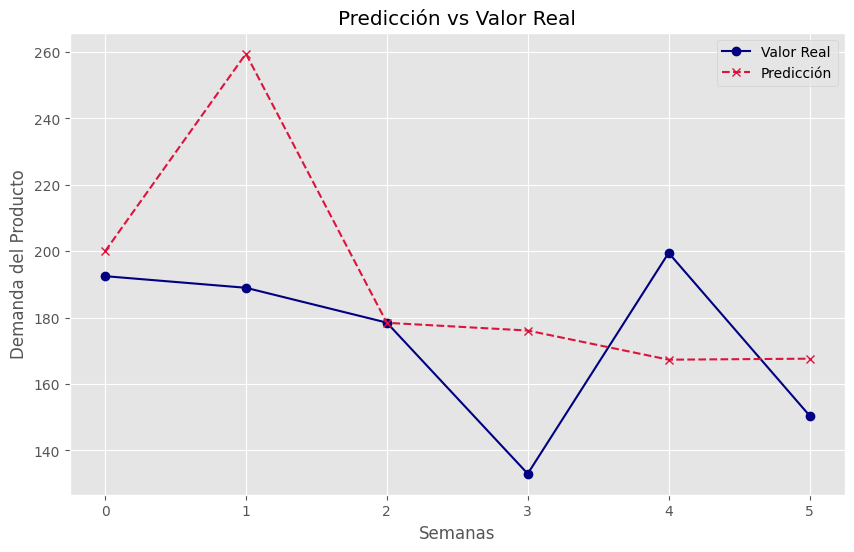

In [378]:
import matplotlib.pyplot as plt

# Graficar las predicciones vs los valores reales
plt.figure(figsize=(10,6))
plt.plot(y_test_inv3, label='Valor Real', color='navy', marker='o')
plt.plot(predicciones_inv3, label='Predicción', color='crimson', linestyle='--', marker='x')
plt.title('Predicción vs Valor Real')
plt.xlabel('Semanas')
plt.ylabel('Demanda del Producto')
plt.legend()
plt.show()


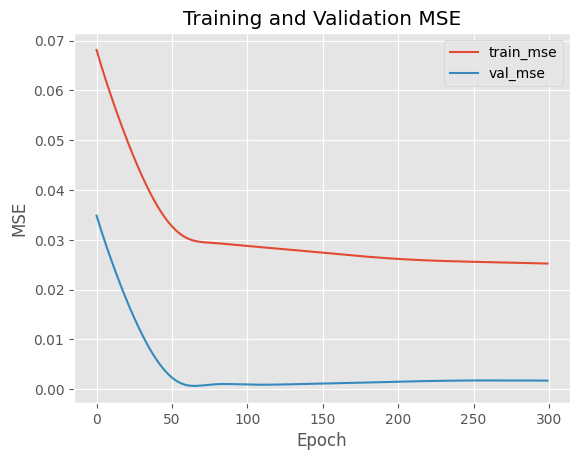

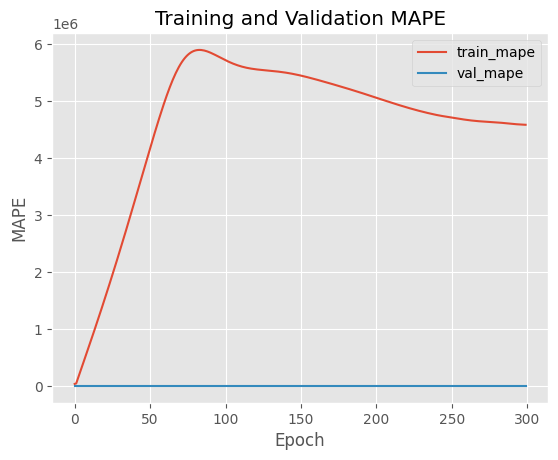

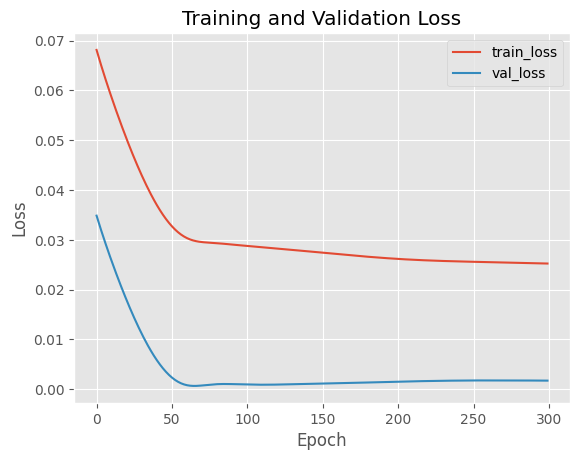

In [379]:
epochs_realizadas = len(Historia3.history['loss'])  

plt.style.use("ggplot")

# MSE
plt.figure()
plt.plot(np.arange(0, epochs_realizadas), Historia3.history["mse"], label="train_mse")
plt.plot(np.arange(0, epochs_realizadas), Historia3.history["val_mse"], label="val_mse")
plt.title("Training and Validation MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()

# MAPE
plt.figure()
plt.plot(np.arange(0, epochs_realizadas), Historia3.history["mape"], label="train_mape")
plt.plot(np.arange(0, epochs_realizadas), Historia3.history["val_mape"], label="val_mape")
plt.title("Training and Validation MAPE")
plt.xlabel("Epoch")
plt.ylabel("MAPE")
plt.legend()

# Loss
plt.figure()
plt.plot(np.arange(0, epochs_realizadas), Historia3.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs_realizadas), Historia3.history["val_loss"], label="val_loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()
